In [1]:
# ====== Cell 1: Install / Imports ======
# !pip install -q seaborn

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from IPython.display import display
from google.colab import files
from google.colab import drive
from PIL import Image, ImageOps
import io
import cv2

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


In [2]:

# ====== Cell 2: Load MNIST Dataset ======
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print("Shapes -> x_train:", x_train.shape, "y_train:", y_train.shape, "x_test:", x_test.shape, "y_test:", y_test.shape)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Shapes -> x_train: (60000, 28, 28) y_train: (60000,) x_test: (10000, 28, 28) y_test: (10000,)


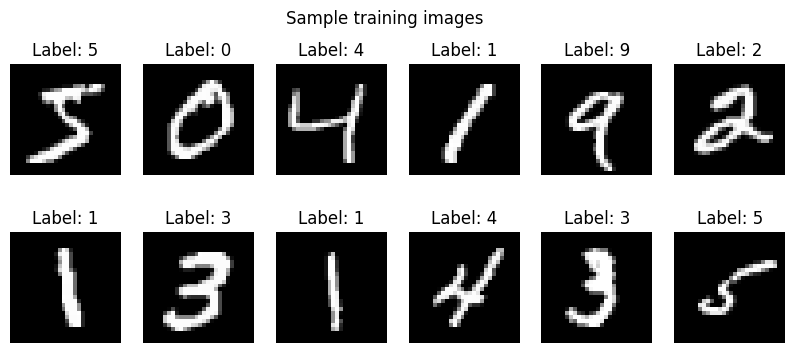

In [4]:
# ====== Cell 3: Quick EDA (Visualize samples & class distribution) ======
# Show some sample images from training set
plt.figure(figsize=(10,4))
for i in range(12):
    plt.subplot(2,6,i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.suptitle("Sample training images")
plt.show()



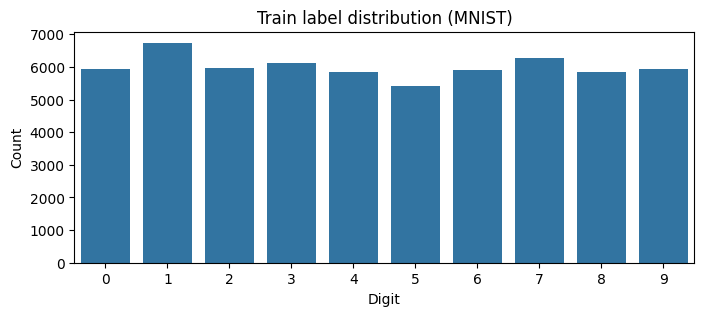

In [5]:
# Class distribution
(unique, counts) = np.unique(y_train, return_counts=True)
plt.figure(figsize=(8,3))
sns.barplot(x=unique, y=counts)
plt.title("Train label distribution (MNIST)")
plt.xlabel("Digit")
plt.ylabel("Count")
plt.show()

In [6]:

# ====== Cell 4: Preprocess & Reshape Data (ADDED FIX) ======
# Normalize pixel values to be between 0 and 1
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Add a channel dimension (for grayscale) as required by the CNN
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# Convert labels to one-hot encoding for categorical_crossentropy
num_classes = 10
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes)

print("Data preprocessed and reshaped.")
print("x_train new shape:", x_train.shape)
print("y_train_cat new shape:", y_train_cat.shape)

Data preprocessed and reshaped.
x_train new shape: (60000, 28, 28, 1)
y_train_cat new shape: (60000, 10)


In [7]:

# ====== Cell 5: Build CNN Model (function) ======
def build_model():
    inp = layers.Input(shape=(28,28,1))
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inp)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs=inp, outputs=out, name="mnist_cnn")
    return model

model = build_model()
model.summary()


Model: "mnist_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 897,418 (3.42 MB)

 Trainable params: 897,162 (3.42 MB)

 Non-trainable params: 256 (1.00 KB)

In [8]:
# ====== Cell 6: Compile & Callbacks ======
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks: ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
ckpt_path = "mnist_cnn_best.h5"
ckpt = callbacks.ModelCheckpoint(ckpt_path, save_best_only=True, monitor='val_accuracy', mode='max')
early = callbacks.EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

print("Callbacks ready. Checkpoint:", ckpt_path)


Callbacks ready. Checkpoint: mnist_cnn_best.h5


In [9]:
# ====== Cell 7: Train the Model ======
# Use validation_split to keep a validation set for monitoring
history = model.fit(
    x_train, y_train_cat,
    validation_split=0.12,
    epochs=25,
    batch_size=128,
    callbacks=[ckpt, early, reduce_lr],
    verbose=2
)


Epoch 1/25


413/413 - 109s - 265ms/step - accuracy: 0.9538 - loss: 0.1516 - val_accuracy: 0.9803 - val_loss: 0.1620 - learning_rate: 1.0000e-03
Epoch 2/25


413/413 - 134s - 324ms/step - accuracy: 0.9840 - loss: 0.0535 - val_accuracy: 0.9896 - val_loss: 0.0347 - learning_rate: 1.0000e-03
Epoch 3/25


413/413 - 158s - 383ms/step - accuracy: 0.9881 - loss: 0.0395 - val_accuracy: 0.9904 - val_loss: 0.0339 - learning_rate: 1.0000e-03
Epoch 4/25
413/413 - 106s - 258ms/step - accuracy: 0.9903 - loss: 0.0304 - val_accuracy: 0.9897 - val_loss: 0.0465 - learning_rate: 1.0000e-03
Epoch 5/25
413/413 - 136s - 330ms/step - accuracy: 0.9920 - loss: 0.0258 - val_accuracy: 0.9904 - val_loss: 0.0427 - learning_rate: 1.0000e-03
Epoch 6/25


413/413 - 139s - 338ms/step - accuracy: 0.9929 - loss: 0.0223 - val_accuracy: 0.9933 - val_loss: 0.0314 - learning_rate: 1.0000e-03
Epoch 7/25
413/413 - 138s - 334ms/step - accuracy: 0.9940 - loss: 0.0190 - val_accuracy: 0.9904 - val_loss: 0.0439 - learning_rate: 1.0000e-03
Epoch 8/25
413/413 - 99s - 240ms/step - accuracy: 0.9948 - loss: 0.0170 - val_accuracy: 0.9910 - val_loss: 0.0418 - learning_rate: 1.0000e-03
Epoch 9/25

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
413/413 - 140s - 340ms/step - accuracy: 0.9950 - loss: 0.0155 - val_accuracy: 0.9917 - val_loss: 0.0370 - learning_rate: 1.0000e-03
Epoch 10/25
413/413 - 142s - 343ms/step - accuracy: 0.9973 - loss: 0.0079 - val_accuracy: 0.9929 - val_loss: 0.0348 - learning_rate: 5.0000e-04
Epoch 11/25
413/413 - 97s - 236ms/step - accuracy: 0.9984 - loss: 0.0044 - val_accuracy: 0.9926 - val_loss: 0.0358 - learning_rate: 5.0000e-04
Epoch 12/25

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500

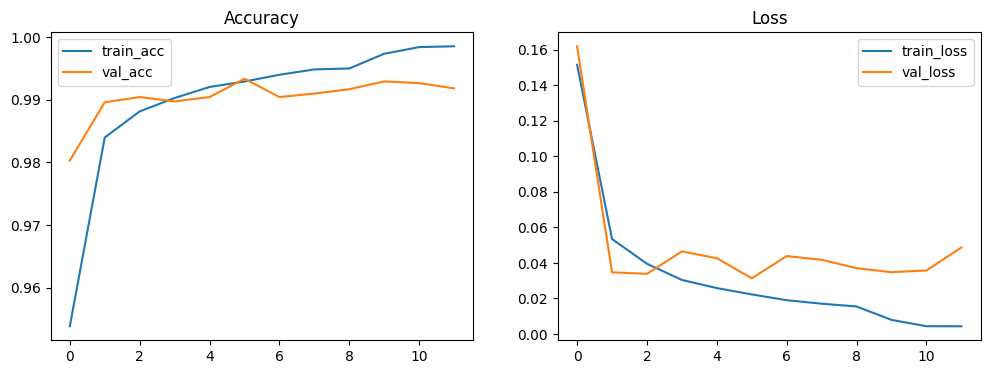

In [10]:
# ====== Cell 8: Plot Training Curves ======
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.legend()
plt.show()

In [11]:

# ====== Cell 9: Evaluate on Test Set ======
test_loss, test_acc = model.evaluate(x_test, y_test_cat, verbose=0)
print(f"Test accuracy: {test_acc*100:.2f}%  |  Test loss: {test_loss:.4f}")


Test accuracy: 99.28%  |  Test loss: 0.0223


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step


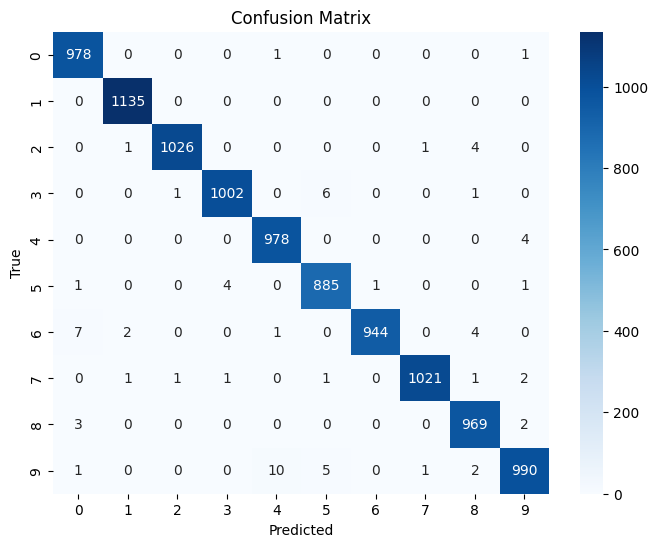

Classification Report:

              precision    recall  f1-score   support

           0     0.9879    0.9980    0.9929       980
           1     0.9965    1.0000    0.9982      1135
           2     0.9981    0.9942    0.9961      1032
           3     0.9950    0.9921    0.9936      1010
           4     0.9879    0.9959    0.9919       982
           5     0.9866    0.9922    0.9894       892
           6     0.9989    0.9854    0.9921       958
           7     0.9980    0.9932    0.9956      1028
           8     0.9878    0.9949    0.9913       974
           9     0.9900    0.9812    0.9856      1009

    accuracy                         0.9928     10000
   macro avg     0.9927    0.9927    0.9927     10000
weighted avg     0.9928    0.9928    0.9928     10000



In [12]:
# ====== Cell 10: Confusion Matrix & Classification Report ======
# Predict and compute confusion matrix
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("Classification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

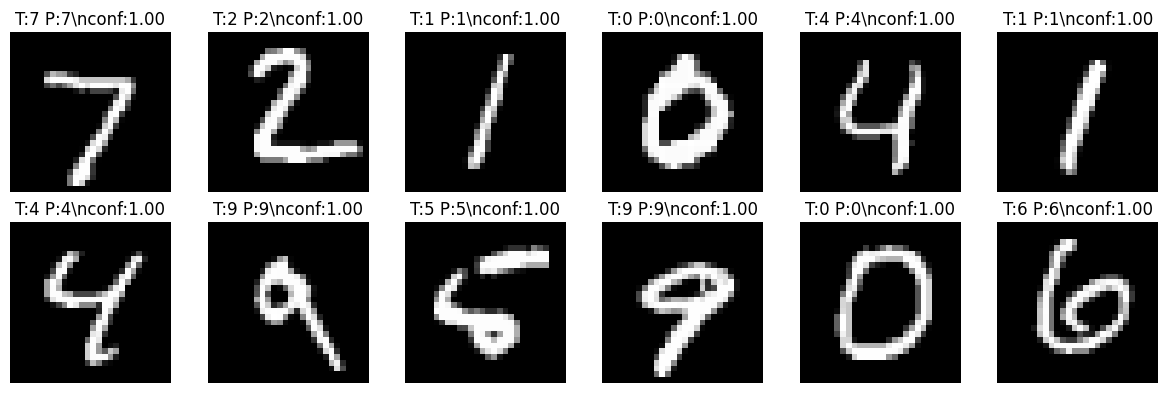

In [13]:
# ====== Cell 11: Show Some Predictions (with confidence) ======
def show_samples(images, true_labels, pred_labels, probs, idxs):
    n = len(idxs)
    cols = min(6, n)
    rows = (n + cols - 1)//cols
    plt.figure(figsize=(cols*2, rows*2))
    for i, k in enumerate(idxs):
        ax = plt.subplot(rows, cols, i+1)
        plt.imshow(images[k].squeeze(), cmap='gray')
        title = f"T:{true_labels[k]} P:{pred_labels[k]}\\nconf:{np.max(probs[k]):.2f}"
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Show first 11 images from the test set
show_samples(x_test, y_test, y_pred, y_pred_probs, idxs=list(range(12)))

In [14]:
# ====== Cell 12: Save Model ======
# Save locally
model.save("mnist_cnn_final.h5")
print("Saved local model as mnist_cnn_final.h5 (and best checkpoint:", ckpt_path, ")")


Saved local model as mnist_cnn_final.h5 (and best checkpoint: mnist_cnn_best.h5 )



Upload an image file (png/jpg) of a handwritten digit:


Saving ChatGPT Image Aug 10, 2025, 03_30_44 PM.png to ChatGPT Image Aug 10, 2025, 03_30_44 PM.png
Processing: ChatGPT Image Aug 10, 2025, 03_30_44 PM.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Predicted digit: 4  |  Confidence: 1.000


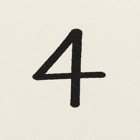

In [15]:
# ====== Cell 13: Upload your own image and predict ======
def preprocess_custom_image(img_bytes):
    # Open image and convert to grayscale
    img = Image.open(io.BytesIO(img_bytes)).convert('L')

    # Convert PIL to numpy for OpenCV processing
    arr = np.array(img)

    # Invert if background is darker than digit (for printed/bold styles)
    if np.mean(arr) < 127:
        arr = 255 - arr

    # Apply binary threshold to clean background
    _, arr = cv2.threshold(arr, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Invert so MNIST style (white digit on black background)
    arr = 255 - arr

    # Resize to 28x28
    img_resized = cv2.resize(arr, (28, 28), interpolation=cv2.INTER_AREA)

    # Normalize to [0,1] and add channel dims
    img_resized = img_resized.astype('float32') / 255.0
    img_resized = np.expand_dims(img_resized, -1)  # (28,28,1)
    img_resized = np.expand_dims(img_resized, 0)   # (1,28,28,1)

    return img_resized

print("\nUpload an image file (png/jpg) of a handwritten digit:")
uploaded = files.upload()
for fn in uploaded.keys():
    print("Processing:", fn)
    arr = preprocess_custom_image(uploaded[fn])
    probs = model.predict(arr)
    pred = np.argmax(probs, axis=1)[0]
    print(f"Predicted digit: {pred}  |  Confidence: {np.max(probs):.3f}")
    # Display uploaded image (original)
    display(Image.open(io.BytesIO(uploaded[fn])).resize((140, 140)))